<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/boltzmann_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ボルツマン分布の作成
Fulcher-αのスペクトルを特定できたので、ボルツマン分布を作成した

In [9]:
!pip install netcdf4 
!pip install git+https://github.com/fujiisoup/pyspectra.git

from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
from google.colab import drive

drive.mount('/content/drive')

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-3ceyyc0z
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-3ceyyc0z
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18317 sha256=bf7529ed29b15acae3a109902fe3736c339aef3c121db9a3ac39a96a84e0c5ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-dt9tau8v/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_dir = join('drive', 'My Drive', '研究室', 'MyLeprecon', 'SpectrometerData', '20201006-2')

file_names = [f'H_{430000 + 5000*i}.nc' for i in range(11)]
data = []
for file_name in file_names:
  data_array = xr.open_dataarray(join(data_dir, file_name))
  data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
  data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

<xarray.DataArray (motor_coordinate: 11, x: 2048)>
array([[1082976, 1083197, 1082899, ..., 1084363, 1084239, 1084094],
       [1082783, 1082709, 1082679, ..., 1083735, 1084333, 1084589],
       [1084277, 1083740, 1083597, ..., 1083131, 1082930, 1082984],
       ...,
       [1086555, 1086688, 1086342, ..., 1088884, 1088554, 1088019],
       [1085457, 1084506, 1084317, ..., 1090590, 1092985, 1095157],
       [1082596, 1083040, 1082501, ..., 1152819, 1162891, 1173495]],
      dtype=uint64)
Coordinates:
    image_counter     int32 0
  * x                 (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * motor_coordinate  (motor_coordinate) int64 430000 435000 ... 475000 480000
    long_x            (motor_coordinate, x) int64 2047 2046 ... -9999 -10000

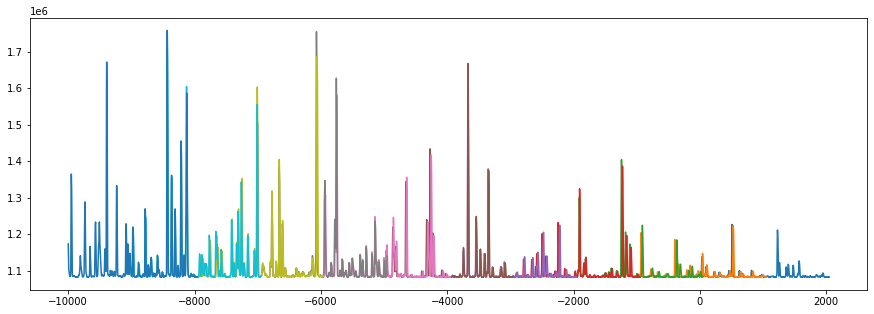

In [11]:
plt.figure(figsize=(15, 5))
long_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  long_data.append(d.sum('y'))
  plt.plot(d['long_x'], d.sum('y'))
long_data = xr.concat(long_data, dim='motor_coordinate')
long_data

### long_data

| long_data | 各セルの縦の合計|
| -- | -- |
| x | 画像のx座標(ピクセル) |
| long_x | 一枚のグラフにしたときのx座標(ピクセル) |

## 各スペクトルのガウスフィッティング

In [12]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

### Q1

(1500.0, 0.0)

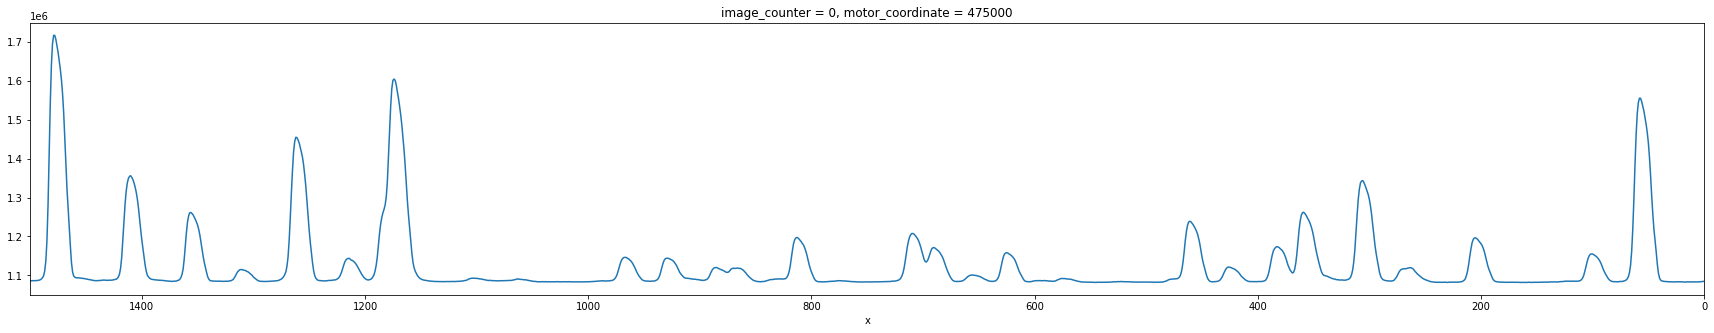

In [13]:
plt.figure(figsize=(30, 5))
long_data.sel(motor_coordinate=475000).plot()
plt.xlim(1500, 0)

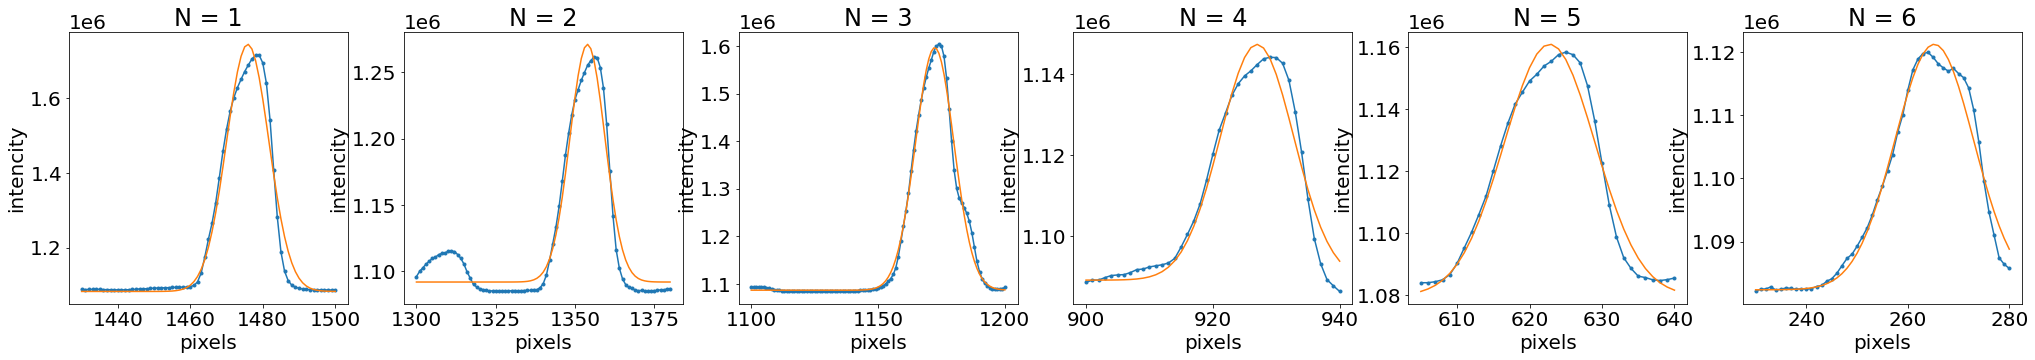

In [31]:
spectrum_lims = [
  [1430, 1500],
  [1300, 1380],
  [1100, 1200],
  [900, 940],
  [605, 640],
  [230, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 5))
Q1_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(long_data.sel(motor_coordinate=475000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 0
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q1_result.append(result)
Q1_result = xr.concat(Q1_result, dim='N')

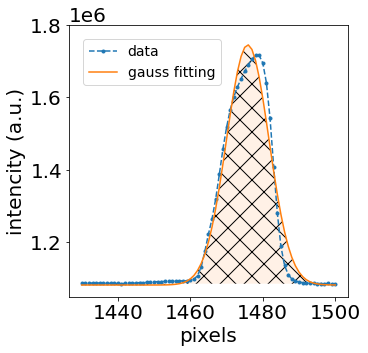

In [20]:
spectrum_lims = [
  [1430, 1500],
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(5, 5))
plt.rcParams['font.size'] = 20
Q1_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(long_data.sel(motor_coordinate=475000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 0
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  result['data'].plot(marker='.', ls='--', label='data')
  result['fit'].plot(label='gauss fitting')
  plt.xlabel('pixels')
  plt.ylabel('intencity (a.u.)')
plt.title('')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=14)
plt.fill_between(result['x'], result['fit'], 1086150, facecolor='C1', hatch='x', alpha=0.1)
plt.ylim(1.05*1e6, 1.8*1e6)
plt.savefig(join('drive', 'My Drive', '研究室', 'images','gauss'), bbox_inches='tight')

Text(0, 0.5, 'area')

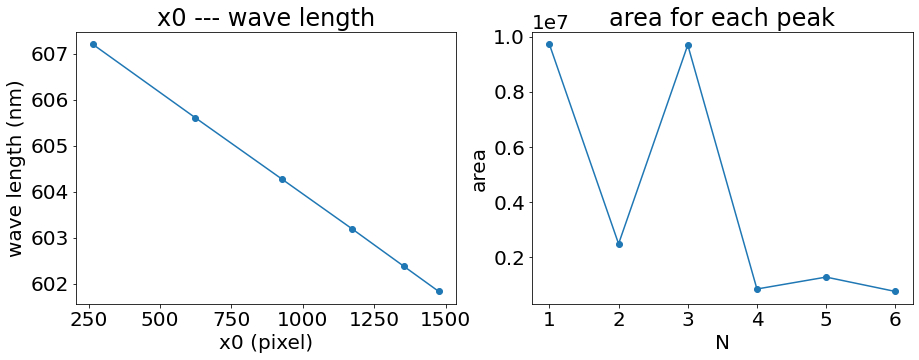

In [32]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q1_result['x0'], Q1_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q1_result['N'], Q1_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

### Q2

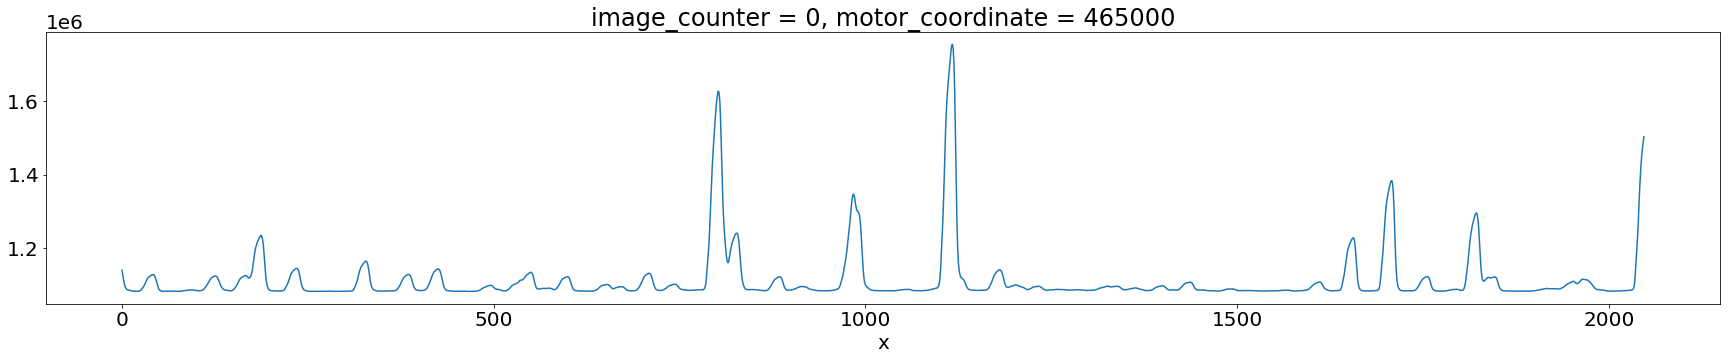

In [21]:
plt.figure(figsize=(30, 5))
long_data.sel(motor_coordinate=465000).plot()

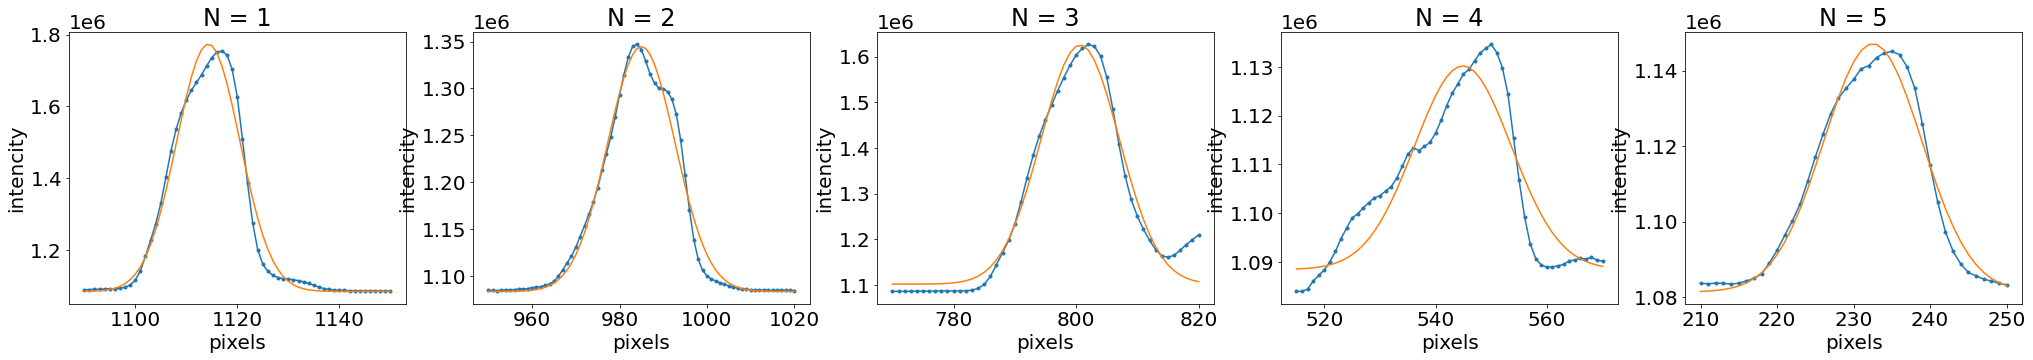

In [22]:
spectrum_lims = [
  [1090, 1150],
  [950, 1020],
  [770, 820],
  [515, 570],
  [210, 250]
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
Q2_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(long_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 1
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q2_result.append(result)
Q2_result = xr.concat(Q2_result, dim='N')

Text(0, 0.5, 'area')

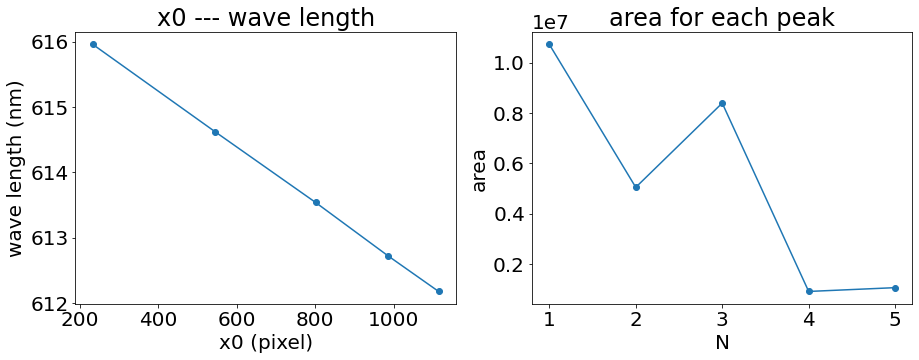

In [23]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q2_result['x0'], Q2_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q2_result['N'], Q2_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

### Q3

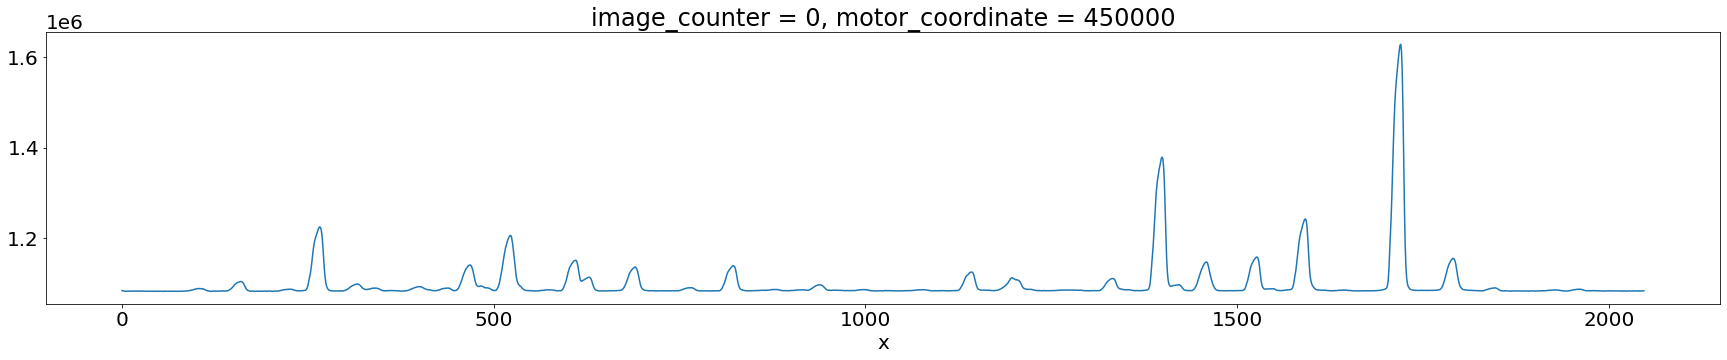

In [24]:
plt.figure(figsize=(30, 5))
long_data.sel(motor_coordinate=450000).plot()

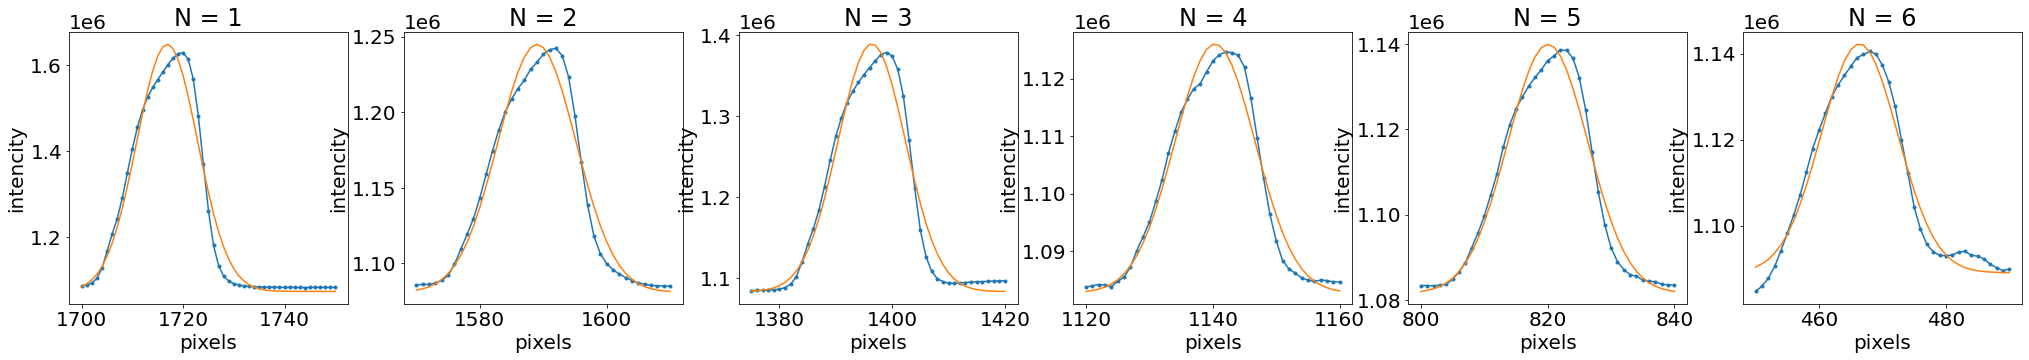

In [25]:
spectrum_lims = [
  [1700, 1750],
  [1570, 1610],
  [1375, 1420],
  [1120, 1160],
  [800, 840],
  [450, 490]
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233
]
plt.figure(figsize=(35, 5))
Q3_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(long_data.sel(motor_coordinate=450000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 2
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q3_result.append(result)
Q3_result = xr.concat(Q3_result, dim='N')

Text(0, 0.5, 'area')

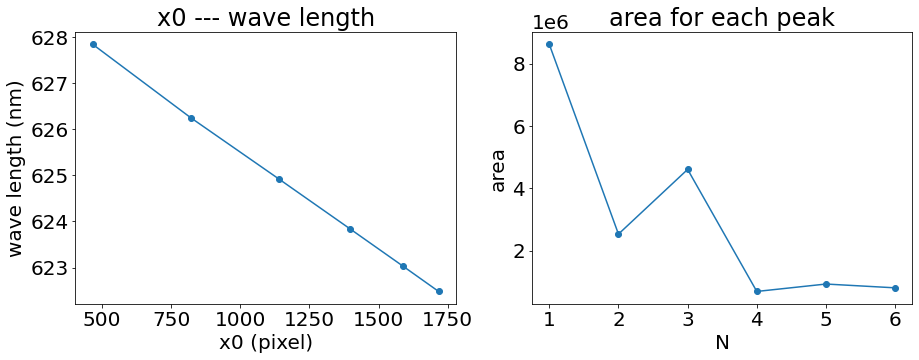

In [26]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q3_result['x0'], Q3_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q3_result['N'], Q3_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

## Estimate population from the intensity

<font color='red'>これは怪しい</font>

$$
A_N \propto n_N g_N g_\mathrm{as} 
$$

$n_N$ : population with the rotational quantum number $N$

$g_N$: statistical weight for the rotational quantum number $N$, $g_N = 2(N+1)$

$g_\mathrm{as}$ : statistical weight for the nuclear symmetry, $g_\mathrm{as} = \mathrm{mod} (N) * 2 + 1$

In [27]:
# d状態の回転エネルギー
def e_rot(v, N):
  return ((30.364-1.545*(v+1/2))*N*(N+1)-0.0191*N*(N+1)*N*(N+1))*1.23984/1e4

# 核スピンの縮退度(核スピンの統計重率)
def g_as(N):
  return (N % 2) * 2 + 1

# 回転の統計重率(もしかしたら二乗じゃ無いかも)
def g_N(N):
  return (2*N+1)*(2*N+1)

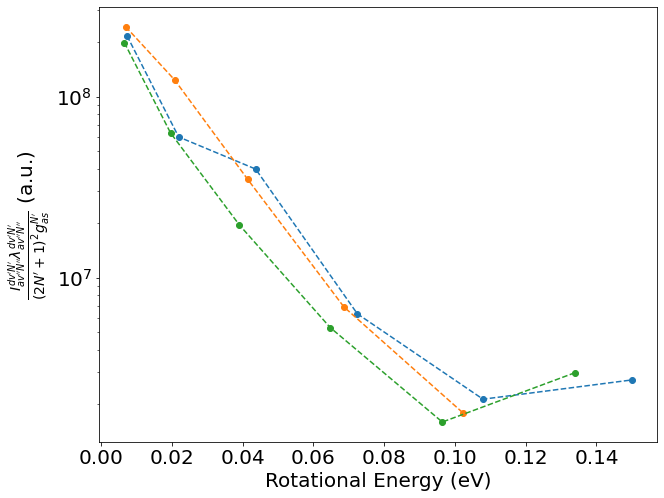

In [35]:
plt.figure(figsize=[10, 8])
plt.rcParams['font.size'] = 20

Q1_population = Q1_result['A'] * Q1_result['wave_length'] / g_N(Q1_result['N']) / g_as(Q1_result['N'])
Q2_population = Q2_result['A'] * Q2_result['wave_length'] / g_N(Q2_result['N']) / g_as(Q2_result['N'])
Q3_population = Q3_result['A'] * Q3_result['wave_length'] / g_N(Q3_result['N']) / g_as(Q3_result['N'])

#plt.subplot(1, 2, 1)
#Q1_population.plot(marker='o', ls='--')
#Q2_population.plot(marker='o', ls='--')
#Q3_population.plot(marker='o', ls='--')
plt.yscale('log')
#plt.title('N --- population')
plt.xlabel('N')
plt.ylabel('population')

#plt.subplot(1, 2, 2)
plt.semilogy(e_rot(Q1_result['v'], Q1_result['N']), Q1_population, marker='o', ls='--')
plt.semilogy(e_rot(Q2_result['v'], Q2_result['N']), Q2_population, marker='o', ls='--')
plt.semilogy(e_rot(Q3_result['v'], Q3_result['N']), Q3_population, marker='o', ls='--')
plt.xlabel('Rotational Energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")

plt.savefig(join('drive', 'My Drive', '研究室', 'images','boltzman'), bbox_inches='tight')

Text(0.5, 1.0, '(v\'-v")=(1-1) Q branch')

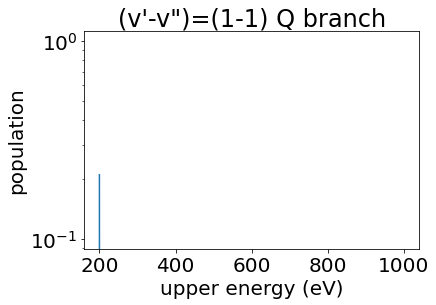

In [29]:
upper_energy = np.arange(200, 1200, 200)
theory_population = np.exp(-(upper_energy / (8.6171*(1e-5))/300)+7735)
plt.semilogy(upper_energy, theory_population, '-')
plt.xlabel('upper energy (eV)')
plt.ylabel('population')
plt.title("""(v'-v\")=(1-1) Q branch""")